<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 6 : Autoencodeurs et détection de fraudes

## Résumé
Le but de ce laboratoire est d'entraîner des autoencodeurs sur des données de transactions bancaires, en mode non supervisé.  La fonction de coût sera la capacité de l'autoencodeur à reproduire en sortie les données d'entrée.  Trois réseaux de neurones autoencodeurs seront testés.

Ensuite, on considérera que les données mal reconstruites sont atypiques, et on testera l'hypothèse qu'il s'agit de transactions frauduleuses.  On utilisera donc cette information pour évaluer la capacité de l'autoencodeur à détecter les fraudes.

In [108]:
import numpy as np
import pandas as pd
import keras # pour l'installation, "pip install tensorflow" suffira

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Données : source

Vous utiliserez un jeu de données fourni par le [Groupe ML de l'Université Libre de Bruxelles](http://mlg.ulb.ac.be/), disponible sur Kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.  Pour simplifier, une version vous est fournie sur Switchdrive dans un fichier [creditcard.zip](https://drive.switch.ch/index.php/s/lBqMRsADWrU2S4R).  Voici la description des données par les auteurs :

> The dataset contains transactions made by credit cards over two days in September 2013 by European cardholders.  It contains only numerical input variables which are the result of a PCA transformation (due to confidentiality issues).  Features V1, ..., V28 are the principal components.  Two features were not transformed: 'Time' (seconds since the 1st transaction) and 'Amount'.  

> The feature 'Class' takes value 1 in case of a fraudulent transaction and 0 otherwise.  There are 492 frauds out of 284,807 transactions (0.17%).  As the dataset is highly unbalanced, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC), not with confusion matrices.

## 1. Charger et préparer les données
a. Chargez les données de `creditcard.csv` directement dans une *dataframe* Pandas appelée `data`.

In [110]:
data = pd.read_csv('data/creditcard.csv')

b. Affichez quelques informations sur ces données et leurs caractéristiques.

In [111]:
data.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [112]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


c. Construisez une nouvelle *dataframe* appelée `data_labels` contenant seulement l'attribut qui indique si une transaction est frauduleuse ou non (attribut `Class`).  Supprimez les attributs `Time` et `Class` de la *dataframe* initiale `data`.

In [113]:
data_labels = data[['Class']]
data.drop(columns=['Time', 'Class'], inplace=True)

d. Normalisez toutes les colonnes de `data` vers des valeurs de moyenne nulle et d'écart-type égal à 1 (distribution centrée réduite). Utilisez pour cela le `StandardScaler` de scikit-learn.

In [114]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
data = pd.DataFrame(normalized_data, columns=data.columns)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


e. Pourquoi est-il acceptable ici de ne pas diviser `data` en données d'entraînement et de test ?

*Réponse :* Car nous allons de toute façon considérer toutes les données lors de l'entraînement. Le fait que certaines transactions soient mal reconstruites de l'autre côté de l'autoencodeur n'a pas de rapport avec le fait qu'elles aient été vues à l'entraînement. La détection d'anomalies se fait en comparant la différence entre la donnée originale et la reconstruction du modèle.

# 2. Définir les fonctions d'évaluation du modèle
Veuillez définir deux fonctions qui affichent :
   1. la courbe précision-rappel et la précision moyenne (qui est aussi la valeur de retour)
   1. la courbe ROC et l'aire sous la courbe (qui est aussi la valeur de retour)

Puis, veuillez recopier leur code et écrire une fonction qui affiche les deux courbes ensemble.

Ces fonctions, spécifiées ci-dessous, utilisent les classes et fonctions importées de `sklearn.metrics` au début de ce notebook.  Veuillez consulter leur documentation pour savoir comment les utiliser.

Une fonction auxiliaire vous est donnée, qui mesure l'erreur de reconstruction entre les données d'origine et celles reconstruites par un autoencodeur.

In [115]:
def reconstruction_error(X_orig, X_pred):
    '''
    Mesure l'erreur de reconstruction pour l'ensemble des données (compare 2 dataframes).
    Retourne une série avec l'erreur de chaque point de données.
    '''
    loss = np.sum((np.array(X_orig) - np.array(X_pred))**2, axis=1) # carré de l'erreur pour chaque item
    loss = pd.Series(data = loss, index = X_orig.index) # transformer en Series
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss)) # normalisation sur tous les items vers [0, 1]
    return loss

Veuillez écrire une fonction pour afficher la courbe précision-rappel et retourner la précision moyenne.  Veuillez écrire une fonction pour afficher la courbe ROC.  Enfin, veuillez copier le code dans une fonction qui affiche les deux courbes ensemble.  Les paramètres des fonctions sont les étiquettes correctes, les valeurs des erreurs de reconstruction, et en option les valeurs prédites par une méthode baseline, affichant ainsi deux courbes si elles sont fournies.  Leurs valeurs de retour sont respectivement la précision moyenne et l'aire sous la courbe ROC.

In [116]:
from sklearn.metrics import precision_recall_curve, roc_curve

def display_pr_curve(labels, rec_errors, baseline=[]):
    precision, recall, _ = precision_recall_curve(labels, rec_errors)

    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()

    idx = np.argmax(precision[:-1])
    threshold = _[idx]
    print(f"Meilleur seuil : {threshold}")
    print(f"Précision associée : {precision[idx]}")
    print(f"Rappel associé : {recall[idx]}")

    mean_precision = average_precision_score(data_labels, rec_errors)
    plt.axhline(y=mean_precision, color='r', linestyle='--', label='Précision moyenne')
    
    if baseline:
        for idx, bl in enumerate(baseline):
            precision_bl, recall_bl, _ = precision_recall_curve(labels, bl)
            plt.plot(recall_bl, precision_bl, linestyle='--', label=f'Modèle Baseline {idx+1}')
    
    plt.legend()
    plt.title("Courbe Précision-Rappel")
    plt.show()


In [117]:
def display_roc_curve(labels, rec_errors, baseline=[]):
    fpr, tpr, _ = roc_curve(labels, rec_errors)

    disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot()

    if baseline:
        for idx, bl in enumerate(baseline):
            fpr_bl, tpr_bl, _ = roc_curve(labels, bl)
            plt.plot(fpr_bl, tpr_bl, linestyle='--', label=f'Modèle Baseline {idx+1}')
    
    plt.legend()
    plt.title("Courbe ROC")
    plt.show()


In [118]:
def display_pr_roc(labels, rec_errors, baseline=[]):
    display_pr_curve(labels, rec_errors, baseline)
    display_roc_curve(labels, rec_errors, baseline)

## 3. Tester des modèles *baseline*

On considère deux modèles *baseline* pour des valeurs de reconstruction:
   1. des scores aléatoires dans [0, 1] pour chaque item : `np.random.rand(data.shape[0])`
   2. la norme L2 du vecteur d'attributs de chaque transaction, normalisée par colonne entre 0 et 1, qui peut être obtenue simplement ainsi avec la fonction définie plus haut : `reconstruction_error(data, np.zeros(data.shape[0]))`
   
Veuillez afficher les courbes précision-rappel et ROC pour ces deux *baselines* en même temps, grâce à la fonction précédente.

Meilleur seuil : 0.034371635602456305
Précision associée : 0.425531914893617
Rappel associé : 0.2032520325203252


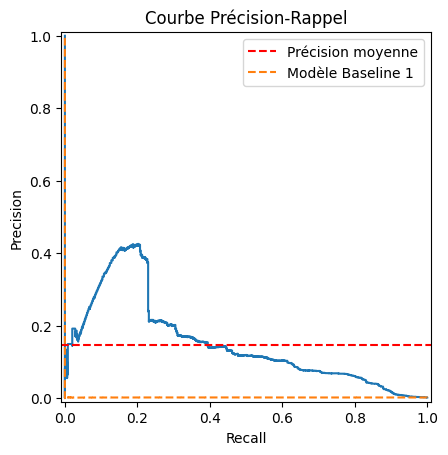

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


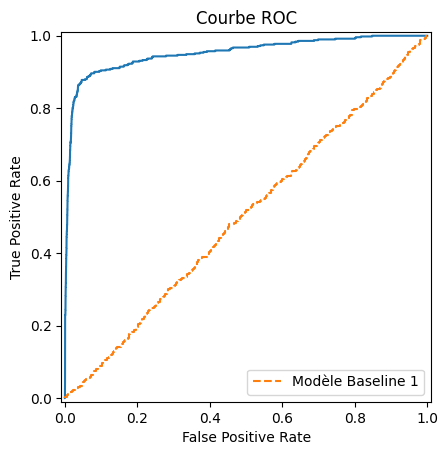

In [119]:
random_pred = pd.DataFrame(np.random.rand(data.shape[0]))
l2Norm = reconstruction_error(data, pd.DataFrame(np.zeros(data.shape[0])))

display_pr_roc(data_labels, l2Norm, [random_pred])

Sachant que les données proviennent d'une transformation PCA des données de transaction originales (auxquelles nous n'avons pas accès), pouvez-vous tenter d'expliquer le score non-nul obtenu par la 2e baseline ?

*Réponse :* La deuxième méthode consiste à calculer la norme du vecteur de features. Visiblement, les transactions frauduleuses doivent avoir une norme particulièrement atypique par rapport aux transactions non-frauduleuses.

## 4. Définir des fonctions pour entraîner, valider, et évaluer des modèles

Veuillez définir une fonction `train` qui entraîne un *modèle* (que vous créerez plus bas avec Keras) sur un jeu de *données*, avec l'objectif de reconstruire les données (donc les données d'entrée et de sortie pour un entraînement supervisé sont identiques).  Toutes les *x* époques d'entraînement (`epochs_per_iteration`) la fonction `train` affiche les scores de *précision moyenne* et de *aire sous la courbe ROC*, mais pas les graphiques.  La fonction itère cela *y* fois (`nb_iterations`).

Veuillez définir aussi une fonction `evaluate` qui affiche les courbes précision-rappel et ROC pour un modèle, et inclut dans chaque graphique la *baseline* de la norme L2 des données initiales (2e baseline de la section 3).

Vous pouvez utiliser ces [méthodes de Keras](https://keras.io/api/models/model_training_apis) :
   * [model.fit(...)](https://keras.io/api/models/model_training_apis/#fit-method) pour lancer un certain nombre de pas d'entraînement (*backward pass*)
   * [model.predict(...)](https://keras.io/api/models/model_training_apis/#predict-method) pour exécuter le modèle sur des données et obtenir la sortie (*forward pass*)

In [120]:
def train(model, data, epochs_per_iteration = 10, nb_iterations = 10):
    for i in range(nb_iterations):
        model.fit(data, data, epochs=epochs_per_iteration, batch_size=128)

        prediction = model.predict(data)
        rec_error = reconstruction_error(data, prediction)

        precision = average_precision_score(data_labels, rec_error)
        roc_auc = roc_auc_score(data_labels, rec_error)
        print('Precision :', precision, '\nAUC :', roc_auc)


In [121]:
def evaluate(model, data, data_labels):
    reconstructed_data = model.predict(data)
    rec_errors = reconstruction_error(data, reconstructed_data)
    l2_baseline = reconstruction_error(data, np.zeros(data.shape))

    display_pr_roc(data_labels, rec_errors, [l2_baseline])


## 5. Créer, entraîner et évaluer des autoencodeurs 

### 5.1. Autoencodeur simple à trois couches

Veuillez définir en Keras un autoencodeur à trois couches, avec une couche de codage ayant une dimension plus faible que celle d'entrée (*undercomplete autoencoder*).  Utiliser un modèle de type `Sequential()` avec des couches entièrement connectées de type `Dense()`, en vous guidant sur les [exemples de Keras](https://keras.io/api/models/sequential/).  Choisissez une fonction de coût (*loss*) et un optimiseur appropriés.  N'oubliez pas de [compiler le modèle](https://keras.io/api/models/model_training_apis/#compile-method) à la fin.

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dimension = len(data.columns)
encoding_dimension = 10

model = Sequential([
    Dense(encoding_dimension, activation='relu', input_shape=(input_dimension,)),
    Dense(input_dimension, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

model.summary()

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 10)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 29)             │           319 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619 (2.42 KB)

 Trainable params: 619 (2.42 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
# model.save('modele_1.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

Veuillez entraîner le modèle avec la fonction `train` que vous avez définie plus haut.  Selon vos résultats intermédiaires, écrivez ici la commande qui semble suffisante pour atteindre le maximum de performance, et affichez ses résultats.  Notez que le modèle est sauvegardé, donc plusieurs appels à `train` permettent de continuer l'entraînement.  Dans votre rapport final, indiquez explicitement la durée totale en nombre d'époques.

In [124]:
train(model, data, epochs_per_iteration=1, nb_iterations=10)

2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step - loss: 0.9978
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step
Precision : 0.15235042906261242 
AUC : 0.9526794181822549
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - loss: 0.8403
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 426us/step
Precision : 0.15322933423130194 
AUC : 0.952799518569021
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step - loss: 0.7934
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 428us/step
Precision : 0.15401574704799142 
AUC : 0.952688668771569
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 676us/step - loss: 0.7895
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 412us/step
Precision : 0.1542269614284066 
AUC : 0.9526192607563837
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - loss: 0.7835
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 427us/step
Precision : 0.1544416166527781 
AUC : 0.9523912558911742
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - loss: 0.8027
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 414us/step
Precision : 0.15471446853949392 
AUC : 0.9521414470867007
2226/2226 ━━━━━━━━━━━━━━━━

Veuillez afficher les deux courbes (y compris les *baselines*), et les scores du modèle avec la fonction `evaluate`.

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 439us/step
Meilleur seuil : 0.03372557480675553
Précision associée : 0.45045045045045046
Rappel associé : 0.2032520325203252


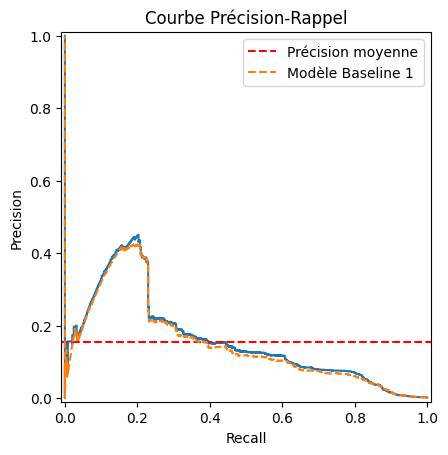

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


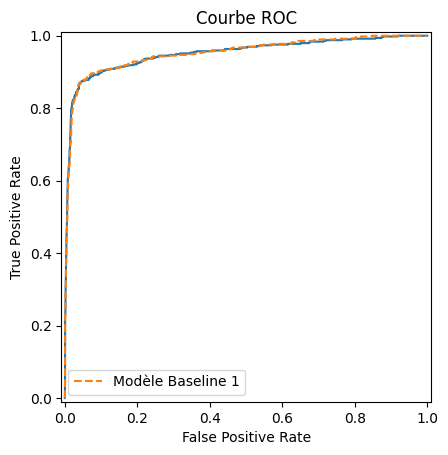

In [125]:
evaluate(model, data, data_labels)

**Veuillez discuter vos résultats.**  Comment jugez-vous la capacité du modèle à détecter des transactions frauduleuses, compte tenu du fait qu'il n'a jamais été entraîné de manière supervisée ?  Comment se compare-t-il avec la baseline ?  Quelle est sa précision maximale, et pour quel rappel est-elle atteinte ?  (Approximativement, d'après le graphique.)  Comment interprétez-vous ces valeurs ?

- Notre modèle basé sur l'utilisation d'un autoencodeur obtient un score similaire à celui basé sur l'utilisation de la norme des features. Étant donné qu'il n'a pas été entraîné de manière supervisée, cela confirme l'hypothèse qu'il est plus difficile de reconstruire des transactions frauduleuses que des transactions non-frauduleuses.
- La précision maximale est de **0.44**, pour un rappel de **0.205**. Ces deux valeurs sont obtenues lorsqu'on fixe le seuil à **0.033**. Cela veut dire que si on prédit correctement 44% des fraudes, on trouve ~20% des vraies fraudes.

### 5.2. Autoencodeur à cinq couches

Veuillez définir maintenant un autoencodeur à cinq couches, sur le même principe que le précédent, toujours *undercomplete*.  Effectuez son entraînement et son évaluation finale, comme pour le modèle à 3 couches.

In [126]:
intermediate_dim = 20
bottleneck_dim = 10

model = Sequential([
    Dense(intermediate_dim, activation='relu', input_shape=(input_dimension,)),
    Dense(bottleneck_dim, activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(input_dimension, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

model.summary()

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 20)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 29)             │           609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639 (6.40 KB)

 Trainable params: 1,639 (6.40 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
train(model, data, 1, 10)

2226/2226 ━━━━━━━━━━━━━━━━━━━━ 3s 839us/step - loss: 0.9414
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 466us/step
Precision : 0.1558559666049565 
AUC : 0.9523364314943819
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 849us/step - loss: 0.8056
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 439us/step
Precision : 0.1567134116251307 
AUC : 0.951612433478326
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 812us/step - loss: 0.7818
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 423us/step
Precision : 0.1567878780646215 
AUC : 0.9513474620000232
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - loss: 0.7656
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 433us/step
Precision : 0.1578988827334318 
AUC : 0.9514944634436584
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - loss: 0.7683
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step
Precision : 0.15809639438381232 
AUC : 0.9512105332614448
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 772us/step - loss: 0.7713
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 438us/step
Precision : 0.15797988034053773 
AUC : 0.9511782777289989
2226/2226 ━━━━━━━━━━━━━━━━━

In [ ]:
# model.save('modele_2.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
Meilleur seuil : 0.03385585689871709
Précision associée : 0.4484304932735426
Rappel associé : 0.2032520325203252


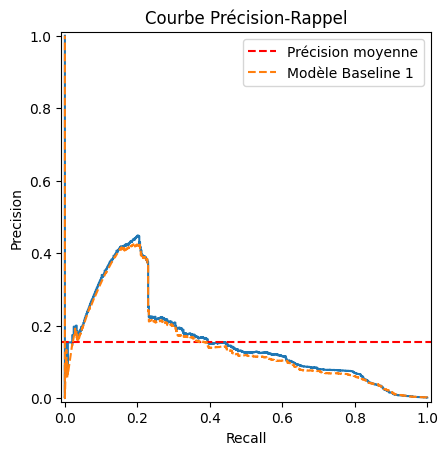

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


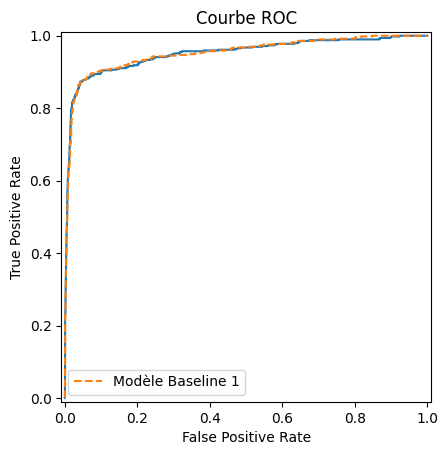

In [129]:
evaluate(model, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

*Réponse :* On obtient quasiment les même résultats qu'avant avec une précision moyenne également similaire.

### 5.3. Autoencodeur à trois couches, *overcomplete*, avec *sparsity*
Veuillez enfin définir un autoencodeur à trois couches, mais avec une couche cachée ayant une dimension supérieure à celle des couches d'entrée et de sortie.  Afin d'éviter la pure copie entrée/sortie, ajoutez une contrainte de régularisation sur la couche cachée, qui limite la somme des valeurs absolues des activations dans cette couche (voir la [documentation](https://keras.io/api/layers/regularizers/) de Keras).

In [130]:
input_dimension = len(data.columns)
encoding_dimension = 35
regularizer = keras.regularizers.l1(1e-4)

model = Sequential([
    Dense(encoding_dimension, activation='relu', input_shape=(input_dimension,), activity_regularizer=regularizer),
    Dense(input_dimension, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

model.summary()

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 35)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 29)             │         1,044 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,094 (8.18 KB)

 Trainable params: 2,094 (8.18 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
train(model, data, 2, 10)

Epoch 1/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - loss: 1.0365
Epoch 2/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step - loss: 0.8392
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 503us/step
Precision : 0.15618945443229826 
AUC : 0.9513430011285147
Epoch 1/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - loss: 0.7724
Epoch 2/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step - loss: 0.7638
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step
Precision : 0.15695009212716593 
AUC : 0.9507785364595465
Epoch 1/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - loss: 0.7377
Epoch 2/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 742us/step - loss: 0.7255
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 439us/step
Precision : 0.15723394474777266 
AUC : 0.9504208875161225
Epoch 1/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step - loss: 0.7163
Epoch 2/2
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - loss: 0.7151
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 413us/step
Precision : 0.15731598801329807 
AUC : 0.9503339934565306
Epoch 1/2
2226/2226 ━━━━━━━━

In [132]:
# model.save('modele_3.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 427us/step
Meilleur seuil : 0.03363430101565765
Précision associée : 0.4608294930875576
Rappel associé : 0.2032520325203252


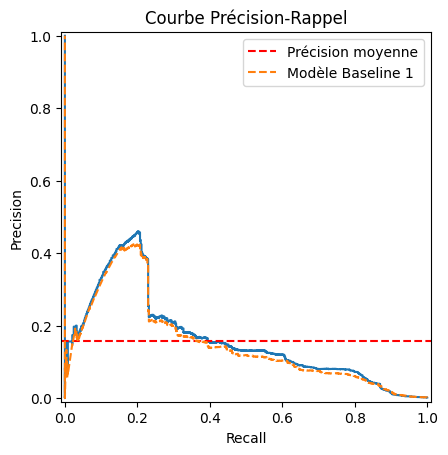

c:\Users\remia\OneDrive\Documents\COURS\S5\APN\heigvd-labos-apn\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


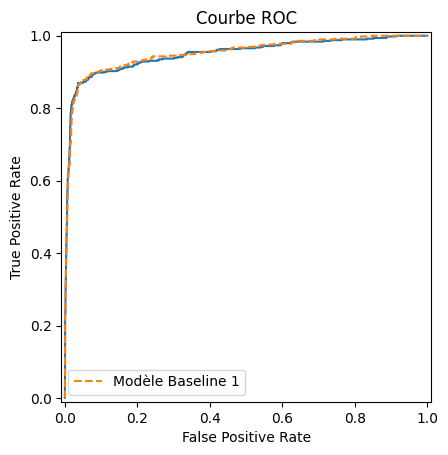

In [133]:
evaluate(model, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

*Réponse :* Nous avons essayé de nombreux changement de méta-paramètres, notamment en changeant le nombre de neurones dans la couche cachée, en changeant le taux de régularisation et la fonction de régularisation. Nos meilleurs résultats ont été obtenus avec une couche cachée de 35 neurones, une régularisation L1 de 1e-4 pour légerement augmenter la précision moyenne. Malgrés nos tentatives, nous n'avons pas réussi à obtenir de résultats significativement meilleurs que les deux modèles précédents. Notre analyse est donc la même que pour le point 5.1.

### Fin du laboratoire 6
Veuillez nettoyer le *notebook* et y inclure l'affichage des résultats de vos systèmes définitifs.  Ne pas effacer les logs d'entraînement et les graphiques.  Veuillez ensuite soumettre le *notebook* sur Cyberlearn.